In [1]:
import numpy as np
import pandas as pd
import os
import time
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
path_folder=os.path.normcase(r'C:\Users\dell\Downloads\Titanic-maching-learning-from-disaster')
train_data=pd.read_csv(os.path.join(path_folder,'train.csv'),sep=',')
test_data_origin=pd.read_csv(os.path.join(path_folder,'test.csv'),sep=',')

In [3]:
def deal_ticket_fare(df):
    '''
    计算每张票有几人共享，以及每人花费的船票钱
    
    paramters:
        df--dataframe，待处理的数据表
        
    return:
        df_count--处理后，添加新列的数据表
    '''
    num_of_tickets=df[['Ticket']].groupby(df['Ticket']).count()
    num_of_tickets.columns=['num_of_tickets']
    df_count=df.merge(num_of_tickets,left_on='Ticket',right_index=True,how='left')
    df_count['fare_per_ticket']=df_count['Fare']/df_count['num_of_tickets']
    return df_count

In [4]:
# 构造 数据预处理 流水线
from sklearn.preprocessing import StandardScaler,OneHotEncoder
from sklearn.pipeline import Pipeline,FeatureUnion
from sklearn.impute import SimpleImputer
from sklearn.base import BaseEstimator,TransformerMixin

class DataFrameSelector(BaseEstimator,TransformerMixin):
    def __init__(self,attrs_name_list):
        self.attrs_name_list=attrs_name_list
    def fit(self,X,y=None):
        return self
    def transform(self,X):
        return X[self.attrs_name_list].values

def data_preparation(cat_attributes,interval_num_attributes,ratio_num_attributes):
    '''
    构造处理DataFrame 的 类
    
    Arguments:
        cat_attributes ---         标称数据列集合
        interval_num_attributes--- 标度数值列集合/不需进行标准化的列集合
        ratio_num_attributes   --- 比例数值列集合/需进行 标准化 列集合
       
    Return 
        full_pipeline---类class
    '''
    cat_attrs=cat_attributes    
    interval_num_attrs=interval_num_attributes
    ratio_num_attrs=ratio_num_attributes
    transformer_list=[]
    
    if cat_attrs:
        cat_pipeline=Pipeline([('cat_dfs',DataFrameSelector(cat_attrs)),('impute',SimpleImputer(strategy='most_frequent')),\
                               ('onehotencoder',OneHotEncoder())])
        transformer_list.append(('cat_pipeline',cat_pipeline))
        
    if interval_num_attrs:
        interval_num_pipeline=Pipeline([('dfs',DataFrameSelector(interval_num_attrs)),('impute',SimpleImputer(strategy='median')) ])
        transformer_list.append(('interval_num_pipeline',interval_num_pipeline))
        
    if ratio_num_attrs:  
        ratio_num_pipeline=Pipeline([('dfs',DataFrameSelector(ratio_num_attrs)),('impute',SimpleImputer(strategy='median')),\
                                     ('std_scaler',StandardScaler())])
        transformer_list.append(('ratio_num_pipeline',ratio_num_pipeline))
    full_pipeline=FeatureUnion(transformer_list=transformer_list)
    return full_pipeline

In [5]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,n_jobs=None, train_sizes=np.linspace(0.1, 1.0, 10)):
    from sklearn.model_selection import learning_curve
    
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)#train_scores size (n_ticks,n_cv_folds)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 's-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

In [6]:
# 计算 预测准确率
def compute_acc(y,y_pred):
    y_pred_class=np.where(y_pred>0.5,1,0)
    pred_accuracy=(y==y_pred_class).astype(np.int).sum()/len(y)    
    return pred_accuracy

In [7]:
# scale 数值数据 数据预处理
train_data_count=deal_ticket_fare(train_data)
from sklearn.model_selection import train_test_split
#train_data_index,dev_data_index=train_test_split(train_data_count.index.tolist(),train_size=0.7,test_size=0.3,random_state=42)
#train_df_data=train_data_count.iloc[train_data_index,:]
#dev_df_data=train_data_count.iloc[dev_data_index,:]
train_df_data,dev_df_data=train_test_split(train_data_count,train_size=0.7,test_size=0.3,random_state=42)
train_data_index=train_df_data.index.tolist()
dev_data_index=dev_df_data.index.tolist()
cat_attrs=['Sex','Embarked']
interval_num_attrs=['Pclass','SibSp','Parch','num_of_tickets']
ratio_num_attrs=['Age','Fare','fare_per_ticket']
full_pipeline_std=data_preparation(cat_attrs,interval_num_attrs,ratio_num_attrs)
#train_data_X=full_pipeline_std.fit_transform(train_df_data).toarray()
#train_data_y=train_df_data['Survived'].values.ravel()
train_data_X=full_pipeline_std.fit_transform(train_data_count).toarray()
train_data_y=train_data_count['Survived'].values.ravel()
train_data_X[0]

array([ 0.        ,  1.        ,  0.        ,  0.        ,  1.        ,
        3.        ,  1.        ,  0.        ,  1.        , -0.56573646,
       -0.50244517, -0.49697568])

In [8]:
dev_data_X=full_pipeline_std.transform(dev_df_data).toarray()
dev_data_y=dev_df_data['Survived'].values.ravel()
dev_data_X[0]

array([ 0.        ,  1.        ,  1.        ,  0.        ,  0.        ,
        3.        ,  1.        ,  1.        ,  2.        , -0.0772525 ,
       -0.32547755, -0.49449441])

In [8]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
rf_clf=RandomForestClassifier(n_estimators=100)
scores=cross_val_score(rf_clf,train_data_X,train_data_y,scoring='accuracy',cv=10)

In [9]:
print('Cross Val Score:',scores.mean())

Cross Val Score: 0.8070619112473045


In [10]:
scores

array([0.75555556, 0.78888889, 0.75280899, 0.83146067, 0.84269663,
       0.85393258, 0.80898876, 0.78651685, 0.82022472, 0.82954545])

In [11]:
rf_clf.fit(train_data_X,train_data_y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [12]:
dev_y_pred=rf_clf.predict(dev_data_X).ravel()
dev_accuracy=compute_acc(dev_data_y,dev_y_pred)
print ('Validation Accuracy:',dev_accuracy)

NameError: name 'dev_data_X' is not defined

<module 'matplotlib.pyplot' from 'C:\\Users\\dell\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

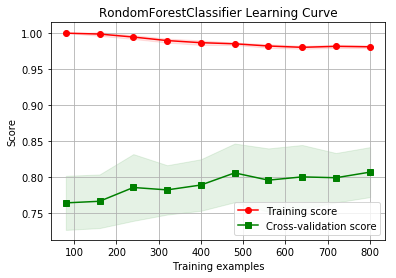

In [13]:
plot_learning_curve(rf_clf,'RondomForestClassifier Learning Curve',train_data_X,train_data_y,cv=10)  #over fitting

In [14]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint as sp_randint
param_dist={'n_estimators':sp_randint(50,70),
            'criterion':['gini','entropy'],
            'max_depth':sp_randint(3,5),
            'min_samples_split':sp_randint(10,20),
            'min_samples_leaf':sp_randint(6,10),
            'bootstrap':[True,False],
           }
rs=RandomizedSearchCV(rf_clf,param_dist,scoring='accuracy',n_jobs=-1,cv=10,return_train_score=True,n_iter=20,iid=True)

In [15]:
rs.fit(train_data_X,train_data_y)

RandomizedSearchCV(cv=10, error_score='raise-deprecating',
          estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
          fit_params=None, iid=True, n_iter=20, n_jobs=-1,
          param_distributions={'criterion': ['gini', 'entropy'], 'bootstrap': [True, False], 'max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000001BEB3317828>, 'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000001BEB33172B0>, 'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000001BEB32C5BE0>, 'min_samples_split': <scipy.stats._distn_infrastructure.rv_frozen 

In [16]:
from sklearn.model_selection import cross_val_score
scores=cross_val_score(rs.best_estimator_,train_data_X,train_data_y,scoring='accuracy',cv=3)
print (scores.mean())

0.809203142536476


In [61]:
len(rs.cv_results_['params'])

20

In [62]:
#rs.cv_results_

In [69]:
rs.best_score_

0.8250401284109149

In [17]:
rs.best_estimator_.get_params()

{'bootstrap': False,
 'class_weight': None,
 'criterion': 'entropy',
 'max_depth': 4,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 9,
 'min_samples_split': 18,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 67,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

<module 'matplotlib.pyplot' from 'C:\\Users\\dell\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

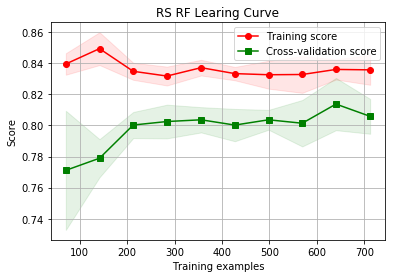

In [18]:
plot_learning_curve(rs.best_estimator_,'RS RF Learing Curve',train_data_X,train_data_y,cv=5)

In [24]:
import joblib
joblib.dump(rs.best_estimator_,'rf.joblib')

['rf.joblib']

In [28]:
svm=joblib.load('SVM.joblib')

In [27]:
test_data=deal_ticket_fare(test_data_origin)
test_data_X=full_pipeline_std.fit_transform(test_data).toarray()

In [29]:
svm_y_pred=svm.predict(test_data_X)
rf_y_pred=rs.best_estimator_.predict(test_data_X)

In [32]:
test_data_origin.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Survived
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q,0
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S,1
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q,0
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S,0
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S,1


In [34]:
test_y_pred=0.7*svm_y_pred+0.3*rf_y_pred
test_data_origin['Survived']=np.where(test_y_pred>0.5,1,0)
test_data_origin[['PassengerId','Survived']].to_csv('c:/users/dell/desktop/gender_submission.csv',index=False)